# Distance calculate


Import libraries

In [10]:
import numpy as np
import cv2
from ultralytics import YOLO
import cv2
import math
import folium
import matplotlib.pyplot as plt
import pandas as pd

### Defining inputs

In [11]:
# Image width = 1024, height = 768
img = cv2.imread(r'D:\python\Distance_measurement\scripts\test_image\human_0.jpg')
print('Width: {}, Height: {}'.format(img.shape[1], img.shape[0]))
# YOLO model
model = YOLO("yolov8n.pt")

# UAV location
UAV_lat = 21.0261309
UAV_lon = 105.8328612

# UAV height (m)
H = 1.22

# Compass angle (degree)
p = 50

# Camera angle (degree)
alpha = 75

# Focal length (mm)
f = 3.29

# Sensor size (mm)
s_w, s_h = 3.67, 2.74

# Resolution
w, h = 1024, 768

Width: 1024, Height: 768


In [12]:
pixcel_w = s_w / w
pixcel_h = s_h / h

print("pixcel width: {} mm".format(pixcel_w))
print("pixcel height: {} mm".format(pixcel_h))
len = pixcel_w * w / 2 
print(math.degrees(math.atan(len/f)))

pixcel width: 0.003583984375 mm
pixcel height: 0.0035677083333333338 mm
29.150626328847988


Calculate focal length

In [13]:
# Pixcel Density
mx = w / pixcel_w
my = h / pixcel_h

fx = f * mx
fy = f * my

ox = w / 2
oy = h / 2

# Instrinsic matrix
M_int = np.array([[fx, 0, ox, 0], [0, fy, oy, 0], [0, 0, 1, 0]])
print(M_int)

[[    9.4e+05           0         512           0]
 [          0  7.0822e+05         384           0]
 [          0           0           1           0]]


In [14]:
img_shape = (int(img.shape[1]), int(img.shape[0]))
P = (int(img_shape[0] / 2), int(img_shape[1] / 2), 0)
B = (0, int(img_shape[1] / 2), 0)
A = (int(img_shape[0] / 2), 0, 0)
C = (int(img_shape[0] / 2), int(img_shape[1]), 0)
O = (int(img_shape[0] / 2), int(img_shape[1] / 2), f)
print(P, B, A, C, O)

(512, 384, 0) (0, 384, 0) (512, 0, 0) (512, 768, 0) (512, 384, 3.29)


##### Applying YOLOv8

Extract xmin, xmax, ymin, ymax

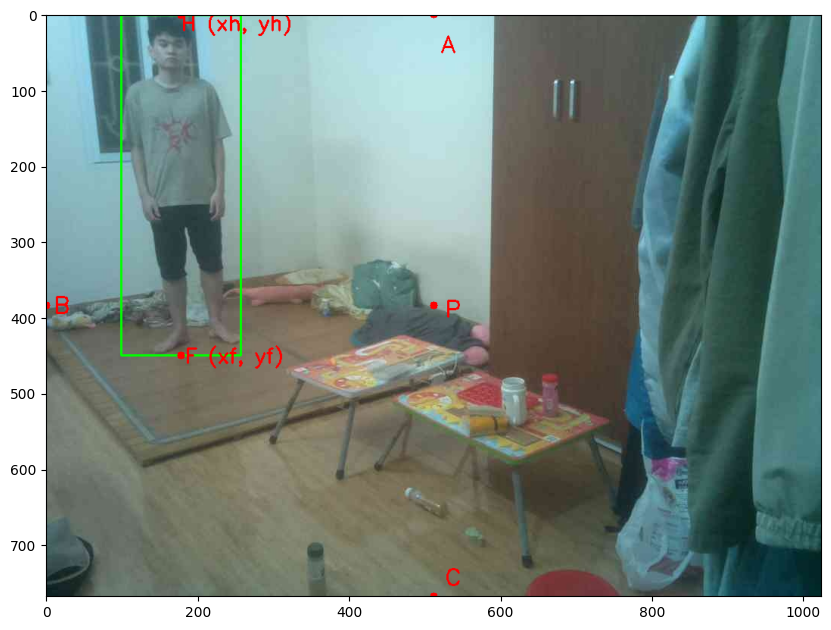

In [15]:
CONFIDENCE_THRESHOLD = 0.8
GREEN = (0, 255, 0)

detections = model(img, verbose=False)[0]
for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]

        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # draw the bounding box on the frame
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        cv2.rectangle(img, (xmin, ymin) , (xmax, ymax), GREEN, 2)
xf = int(0.5 * (xmin + xmax))
yf = int(ymax)

xh = int (0.5 * (xmin + xmax))
yh = int(ymin)
F = (xf, yf, 0)

cv2.circle(img, (xf, yf), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (xh, yh), radius=5, color=(0, 0, 255), thickness=-1)

cv2.circle(img, (B[0], B[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (A[0], A[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (P[0], P[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (C[0], C[1]), radius=5, color=(0, 0, 255), thickness=-1)

cv2.putText(img, "F (xf, yf)", (xf + 5, yf + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.putText(img, "H (xh, yh)", (xh, yh + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

cv2.putText(img, "B", (B[0] + 10, B[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "A", (A[0] + 10, A[1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "P", (P[0] + 15, P[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "C", (C[0] + 15, C[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

##### Visualize method

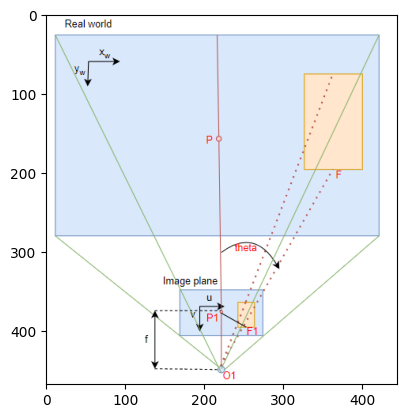

In [16]:
visualize_img1 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize1.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img1, cv2.COLOR_BGR2RGB))
plt.show()

##### Angle calculation

In [17]:
PFx = (F[0] - P[0])*pixcel_w
PFy = (F[1] - P[1])*pixcel_h
PF = math.sqrt(PFx**2 + PFy**2)
print("PF: {} mm".format(PF))
theta = math.degrees(math.atan(PF/f))
print("theta = {} degree".format(theta))


PF: 1.2199902069761863 mm
theta = 20.345671557949252 degree


Read distance measurement

   UAV height  h1 (m)  h2 (m)  Distance from UAV (m)  Distance (pixcel)
0        0.44    0.64    0.88                   1.52                NaN
1        0.76    1.10    1.40                   2.50                NaN
2        0.81    1.22    1.70                   2.92                NaN
3        1.00    1.36    1.56                   3.10                NaN
4        1.22    1.61    2.59                   4.20                NaN


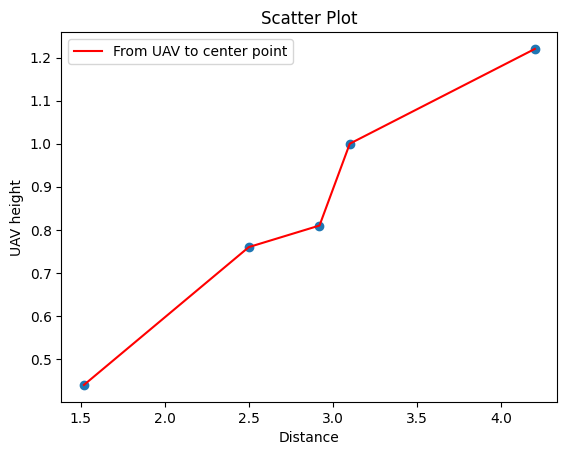

In [18]:
df = pd.read_csv(r'D:\python\Distance_measurement\scripts\visualize\real_distance.csv')
# To display the first 5 rows of the dataframe
print(df.iloc[:, :5])
y_val = df.iloc[:, 0]
x_val = df.iloc[:, 3]
plt.scatter(x_val, y_val)
# Draw a red line connecting the dots
plt.plot(x_val, y_val, color='red', label = "From UAV to center point")
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('UAV height')
plt.title('Scatter Plot')
plt.legend()

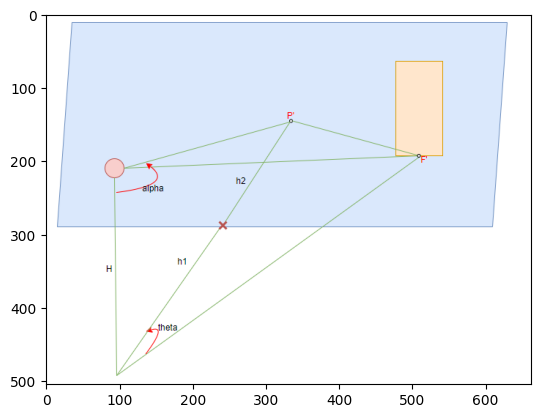

In [19]:
visualize_img2 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize2.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img2, cv2.COLOR_BGR2RGB))
plt.show()

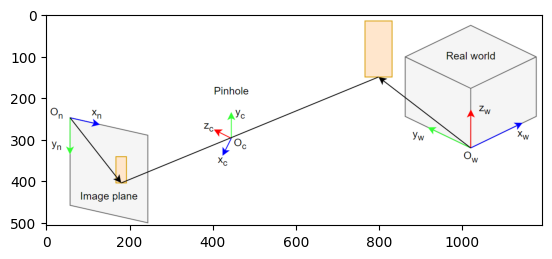

In [21]:
visualize_img3 = cv2.imread(r'D:\python\Distance_measurement\scripts\visualize\visualize3.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img3, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
m = folium.Map(location=[UAV_lat, UAV_lon], zoom_start=30)
folium.Marker(location=[UAV_lat, UAV_lon], popup='UAV').add_to(m)

length = 0.0001
end_lat = UAV_lat + length * math.cos(math.radians(p))
end_lon = UAV_lon + length * math.sin(math.radians(p))

end_lat_direct = UAV_lat + length * math.cos(math.radians(p + theta))
end_lon_direct = UAV_lon + length * math.sin(math.radians(p + theta))

# Draw the compass line
folium.PolyLine([(UAV_lat, UAV_lon), (end_lat, end_lon)], color="red").add_to(m)
# Draw the direct line
folium.PolyLine([(UAV_lat, UAV_lon), (end_lat_direct, end_lon_direct)], color="blue").add_to(m)

m    